In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product

from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn import metrics # silhouette
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import hmean

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.head()

,id,date,title,body,subjects,category
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Vuonna 1973 autonvalmistaja Volkswagen oli kr...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Poliisi kaipaa edelleen havaintoja keskiviikk...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Etelä-Pohjanmaalla asuva nuori nainen menehty...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Kun auton polttimonvaihto vie alan korjaamoll...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,Kokemäellä autoillut mies jäi keskiviikkona k...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot


In [4]:
# df.drop_duplicates(subset ="id", inplace=True, ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207881 entries, 0 to 207880
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        207881 non-null  object
 1   date      207881 non-null  object
 2   title     207881 non-null  object
 3   body      207881 non-null  object
 4   subjects  207881 non-null  object
 5   category  207881 non-null  object
dtypes: object(6)
memory usage: 11.1+ MB


In [48]:
df['id'].nunique()

207881

In [6]:
df['body'] = df['title'] + '. ' + df['body']

In [7]:
# load trained doc2vec model
d2v = Doc2Vec.load('models/doc2vec_full')

In [6]:
# infering to sample docs
def infer_doc2vec(docs, model):
    # tokenize the docs
    tokenized = docs.apply(simple_preprocess)
    vecs = np.zeros((len(docs), model.vector_size))
    
    for i, tokens in enumerate(tokenized):
        vecs[i] = model.infer_vector(tokens)
    
    return vecs

In [ ]:
%%time
doc_vecs = infer_doc2vec(df['body'], d2v)

In [ ]:
pickle.dump(doc_vecs, open("data/dev/doc_vecs.pkl", "wb"))

In [3]:
doc_vecs = pickle.load(open("data/dev/doc_vecs.pkl", "rb"))

In [2]:
def get_doc_vecs(doc_vecs, df, ids):
    df2 = df.reset_index()
    df2 = df2.set_index('id')

    indexes = df2.loc[ids, 'index'].tolist()
    # print(len(indexes))
    vecs = doc_vecs[indexes]
    
    return vecs

def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

In [3]:
dataset = pickle.load(open("data/dev/topic_change.pkl", "rb"))

In [6]:
df.drop(['title', 'body', 'subjects'], axis=1, inplace=True)

In [7]:
len(dataset)

100

In [7]:
#sample = dataset[4].sample(frac=0.3)
sample = dataset[23]

In [8]:
sample.head()

,id,category,target,time
59929,3-7702862,luonto,False,72
80038,3-5377778,rikokset,False,82
98955,3-9849747,taudit,False,89
96540,3-6401746,taudit,False,68
8240,3-8664561,autot,False,56


In [9]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132384 entries, 59929 to 108474
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        132384 non-null  object
 1   category  132384 non-null  object
 2   target    132384 non-null  bool  
 3   time      132384 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
def get_target(df):
    target = df[df['target'] == True]['category'].iloc[0]
    return target

In [11]:
target = get_target(sample)
print(target)

kulttuuri


In [74]:
sample['category'] = sample['category'].astype('category')
sample.sort_values('category', inplace=True)
sample.reset_index(inplace=True, drop=True)

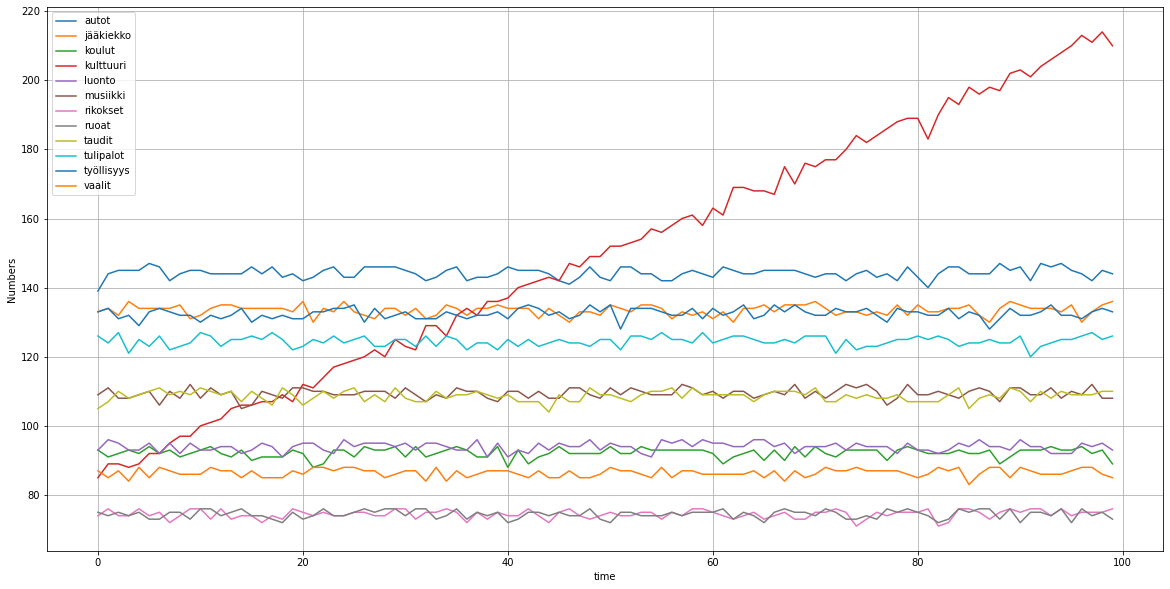

In [75]:
visualize_trending(sample)

In [76]:
sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])

In [77]:
len(sample_vecs)

132384

In [78]:
%%time
# clutering = AffinityPropagation(random_state=12).fit(sample_vecs)
clutering = KMeans(n_clusters=12, random_state=12).fit(sample_vecs)

CPU times: user 54.7 s, sys: 644 ms, total: 55.3 s
Wall time: 10.2 s


In [79]:
clusters = clutering.labels_

In [81]:
labels = sample['category'].cat.codes

In [82]:
metrics.fowlkes_mallows_score(labels, clusters)

0.3638851811965152

In [87]:
def search_n_cluster(data, labels, max_cluster=50, start=10, step=5):
    scores = []
    x = range(start, max_cluster + 1, step)
    
    for n in x:
        model = KMeans(n_clusters=n, random_state=12).fit(data)
        preds = model.labels_
        score = metrics.fowlkes_mallows_score(labels, preds)
        scores.append(score)
        
    
    plt.plot(x, scores)
    plt.xlabel("Num clusters")
    plt.ylabel("FM score")
    plt.show()

    return scores

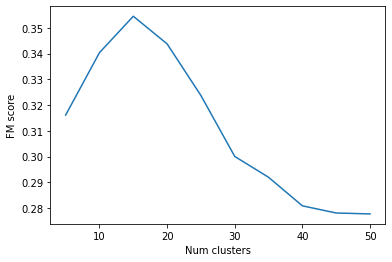

In [88]:
fm_scores = search_n_cluster(sample_vecs, labels, max_cluster=50, start=5, step=5)

In [27]:
#sh_score = metrics.silhouette_score(sample_vecs, clusters)

In [28]:
# sh_score

-0.05666181749769397

In [ ]:
# 0.010890652768570678

In [ ]:
# centers = af.cluster_centers_indices_
# print('n_cluster', len(centers))

In [18]:
def get_cluster_change(clusters, sample):
    sample['cluster'] = clusters
    n_cluster = sample['cluster'].nunique()
    changes = []
    
    for g, cluster in sample.groupby('cluster'):
        # count and sort by timeline
        counts = cluster['time'].value_counts().sort_index()
        maj_class = cluster['category'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((g, maj_class, counts))
        
    return changes
        

In [19]:
changes = get_cluster_change(clusters, sample)

In [47]:
changes[0][1]

'vaalit'

In [20]:
def visualize_changes(changes, target):    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    distance = 0
    target_id = 0
    for cluster, maj_class, counts in changes:
        val = counts.values + distance
        if maj_class == target:
            target_id = cluster
            ax.plot(counts.index, val, label=maj_class, ls='--')
        else:
            ax.plot(counts.index, val, label=maj_class)
            
        distance += 20
    
    ax.set(xlabel='Time', ylabel='Counts')
    ax.legend()
    ax.grid()

    plt.show()
    print('cluster target:', target_id)
    return target_id

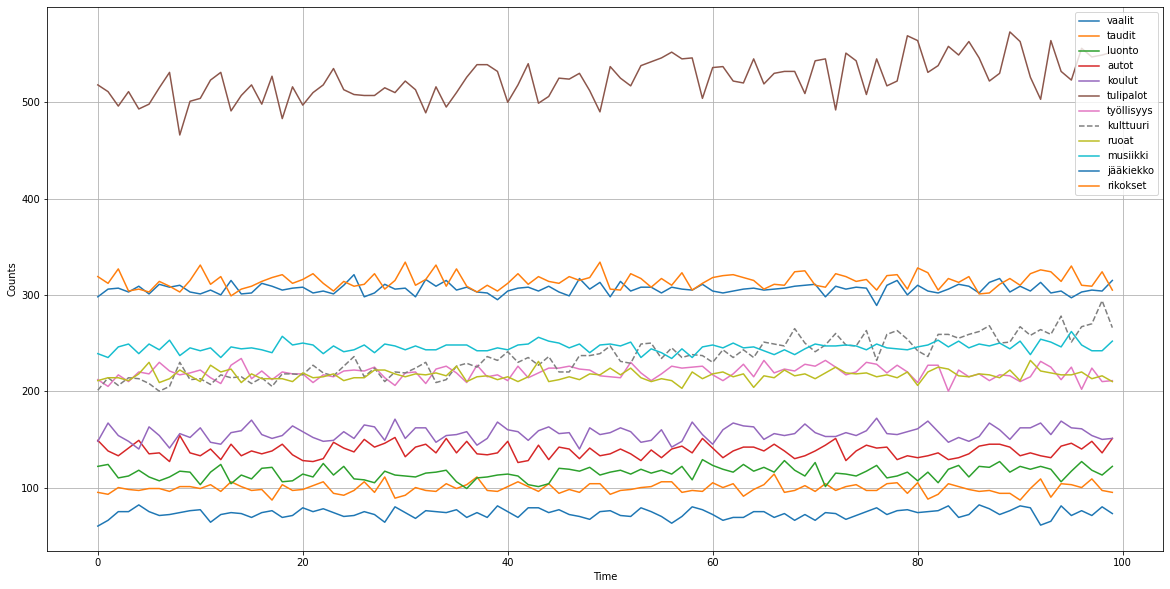

cluster target: 7


In [21]:
target_id = visualize_changes(changes, target)

In [144]:
# sample[sample['cluster'] == target_id]

In [42]:
def cal_change_slope(freqs, timeline):
    X = np.arange(timeline)[:, np.newaxis]
    reg = LinearRegression(normalize=True).fit(X, freqs)
    
    return reg.coef_[0]

def get_slopes_window(freqs, timeline, window=5):
    steps = timeline - window + 1
    X = np.arange(window)[:, np.newaxis]
    
    slopes = np.zeros(steps)
    
    for i in range(steps):
        y = freqs[i:i+window]
        reg = LinearRegression(normalize=True).fit(X, y)
        slopes[i] = reg.coef_[0]
        
    return slopes
    

In [43]:
slopes = get_slopes_window(changes[target_id][2], 100, window=5)
# cal_change_slope(changes[target_id][2], 100)

In [41]:
print(slopes)

[ 2.4 -0.5 -1.8 -3.1  3.1  3.8  3.3 -1.3 -3.1  0.8  1.1  0.  -1.2 -1.9
  0.3  2.4  1.9  4.3  1.1 -0.2  0.7  2.5  1.2  0.5 -4.4 -3.7  0.4  0.9
  4.4 -1.1 -2.9 -1.4  1.5  4.9  4.7  1.9  3.1  1.5 -0.4 -1.6 -1.3 -1.9
 -3.7  0.4  1.9  5.5  5.6 -0.2 -2.4  0.2  2.4  2.7  1.7 -3.3 -2.3 -0.1
 -2.8  0.8  0.   1.7  1.   1.6  3.6  2.2  5.6  1.4 -1.3 -2.2 -1.2  1.5
  1.2  1.7 -4.1  0.7  2.8  1.3  1.5 -6.7 -2.6  2.7  4.9  4.2  0.6  2.5
 -0.1 -2.8 -0.7 -0.3  3.5  1.3  2.3  0.  -0.2  1.1  5.1  5.7]


In [47]:
def get_batch_slopes(changes, timeline, window=5):
    all_slopes = []
    categories = []
    x = np.arange(len(changes))
    
    for cluster, maj_class, freqs in changes:
        slopes = get_slopes_window(freqs, timeline, window)
        all_slopes.append(slopes)
        categories.append(maj_class)
    
    all_slopes = np.abs(np.array(all_slopes))
    #slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    
    return all_slopes, categories
    
    
def get_slopes(changes, timeline, visualize=False):
    slopes = []
    categories = []
    x = np.arange(len(changes))
    
    for cluster, maj_class, freqs in changes:
        slope = cal_change_slope(freqs, timeline)
        slopes.append(slope)
        categories.append(maj_class)
    
    slopes = np.abs(np.array(slopes))
    slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    
    if visualize:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.bar(x, height=slopes, tick_label=categories)
        ax.set(xlabel='Clusters', ylabel='Slopes')
    
    return slopes, categories


In [66]:
slopes, cats = get_batch_slopes(changes, 100, window=20)

In [67]:
def visualize_slopes_window(slopes, cats, target):
    timeline = range(slopes.shape[1])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    distance = 0
    slopes = slopes
    
    for i, c in enumerate(cats):
        if c == target:
            ax.plot(timeline, slopes[i] + distance, label=c, ls='--')
        else:
            ax.plot(timeline, slopes[i] + distance, label=c)
        
        distance += 2
    
    ax.set(xlabel='Clusters', ylabel='Slopes')
    ax.legend()
    ax.grid()
    fig.show()

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


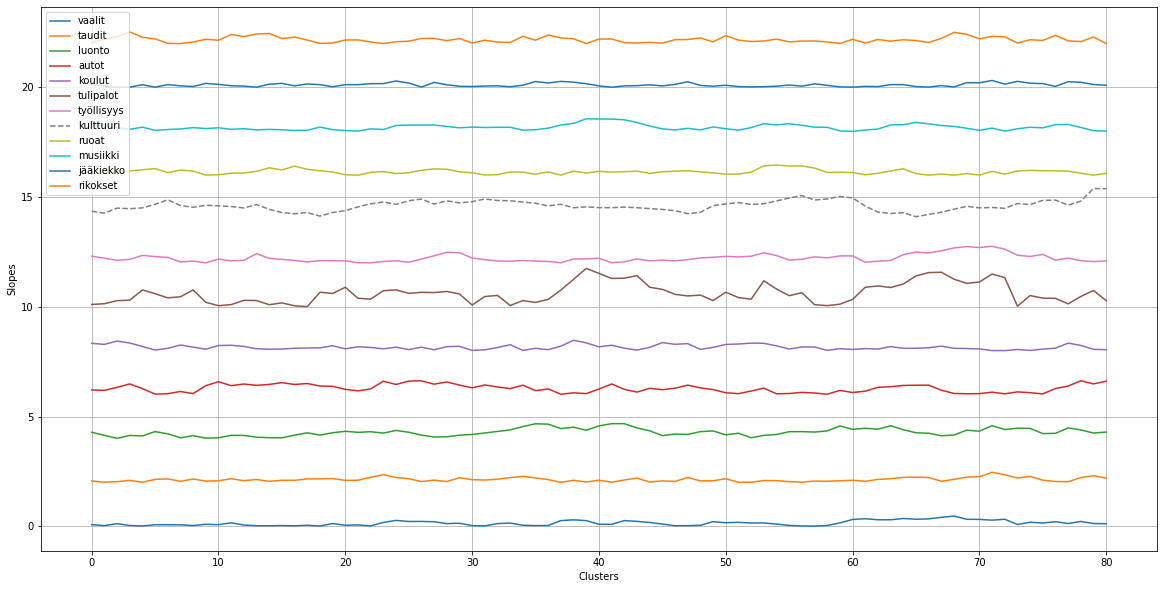

In [68]:
visualize_slopes_window(slopes, cats, target)

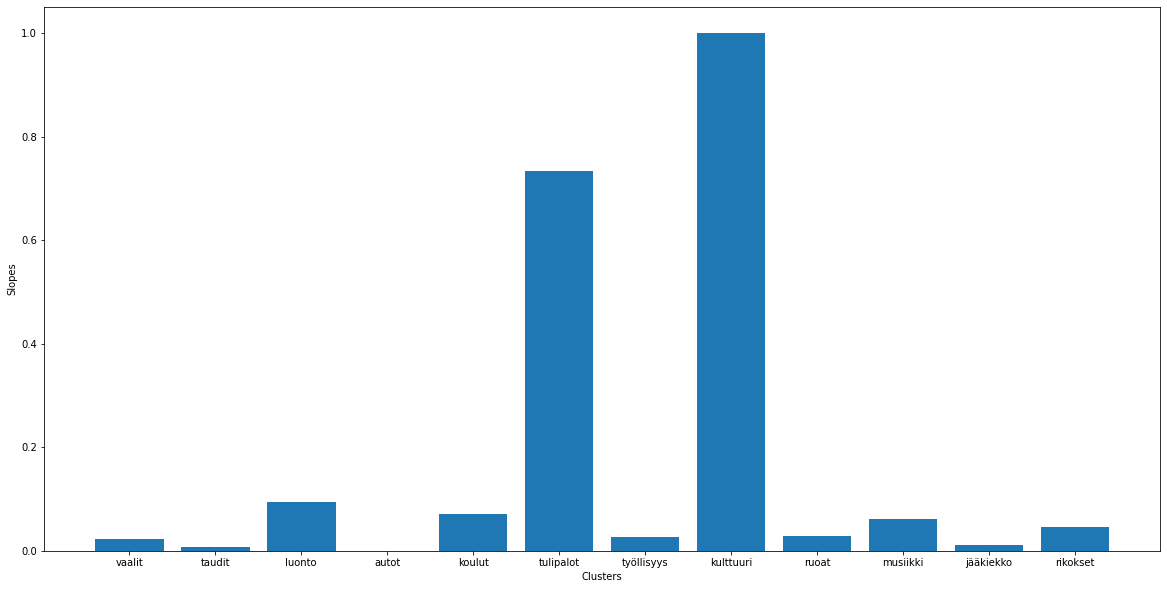

In [26]:
slopes, cats = get_slopes(changes, 100, visualize=True)

In [205]:
print(cats)

['rikokset', 'tulipalot', 'vaalit', 'autot', 'musiikki', 'koulut', 'ruoat', 'luonto', 'jääkiekko', 'taudit', 'kulttuuri', 'taudit']


In [86]:
def get_metrics(df, slopes, maj_cats, target, threshold=0.4):
    accuracy = 0   # accuracy of detect correctly clusters have the target category as major
    precision = 0  # accuracy of detect how many articles in cluster are target category
    recall = 0    # accuracy of detect how many articles in target category are in choosen clusters
    
    # slopes = np.abs(np.array(slopes))
    pred_ids = np.argwhere(slopes >= threshold).squeeze(1)
    n_cluster = len(pred_ids)
    target_cluster = df[df['target'] == True]
    
    for i in pred_ids:
        pred_cat = maj_cats[i]
        cluster = df[df['cluster'] == i]
        
        if pred_cat == target:
            accuracy += 1
        # calculate the prec and recall
        
        precision += cluster['target'].mean()
        recall += cluster['target'].sum()
    
    # if there is output 
    if n_cluster:
        accuracy = accuracy / n_cluster
        precision = precision / n_cluster
        recall = recall / target_cluster.shape[0]
    
    return accuracy, precision, recall
    
    

In [230]:
get_metrics(sample, slopes, cats, target, threshold=0.8)

(0.5, 0.5054606141438663, 0.8837519220912352)

In [258]:
def evaluate_pipeline(samples, df, k=12, threshold=0.5, timeline=100):
    n_samples = len(samples)
    acc = np.zeros(n_samples)
    prc = np.zeros(n_samples)
    rec = np.zeros(n_samples)
    f = np.zeros(n_samples)
    
    for i, sample in enumerate(tqdm(samples)):
        sample.reset_index(inplace=True, drop=True)
        sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        target = get_target(sample)
        
        clutering = KMeans(n_clusters=k, random_state=12).fit(sample_vecs)
        clusters = clutering.labels_
        freq_changes = get_cluster_change(clusters, sample)
        
        slopes, cats = get_slopes(freq_changes, timeline)
        
        acc[i], prc[i], rec[i] = get_metrics(sample, slopes, cats, target, threshold)
        f[i] = 2* prc[i] * rec[i] / (prc[i] + rec[i])
        
    return acc, prc, rec, f
    

In [259]:
accs, precs, recs, f_micro = evaluate_pipeline(dataset, df, k=12, threshold=0.8, timeline=100)

100%|██████████| 100/100 [17:48<00:00, 10.69s/it]


In [260]:
f_macro =2 * precs.mean()*recs.mean()/(precs.mean()+recs.mean())
accs.mean(), precs.mean(), recs.mean()

(0.965, 0.7969002902199377, 0.6258688026308521)

In [261]:
print("f_micro:", f_micro.mean(), "f_macro:", f_macro)

f_micro: 0.6807925450493311 f_macro: 0.7011046739239744


In [234]:
err_cluster = np.argwhere(accs == 0)

In [235]:
len(err_cluster)

1

In [ ]:
# 0.3: (0.745, 0.6343292998172704, 0.7697123051348668)
# 0.4: (0.89, 0.7395639037789224, 0.6563455287820337)
# 0.5: (0.8, 0.6640593814713934, 0.512341135418601)


# 0.8: (0.965, 0.7969002902199377, 0.6258688026308521)
# 0.7: (0.935, 0.7743919976040927, 0.6444361047009539)

# More noise: (0.9016666666666666, 0.7086314813655319, 0.6674593527094121)